# Authors:

Daniel Vila de la Cruz

Sara Gómez Feás

# Parameters

In [1]:
IMAGE_SIZE = 32
CHANNELS = 3

BATCH_SIZE = 64
NUM_FEATURES = 128
Z_DIM = 128

EPOCHS = 10
STEPS_PER_EPOCH= 100

LEARNING_RATE = 0.0002
CRITIC_STEPS = 3

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

# Data preprocess

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers

import matplotlib.pyplot as plt
import numpy as np

In [6]:
#! ls /content/drive/MyDrive/g_dataset/img_align_celeba/img_align_celeba/ | grep "000001.jpg"
! ls /content/drive/MyDrive/img_align_celeba/img_align_celeba/ | grep "000001.jpg"

000001.jpg


In [7]:
data_dir = '/content/drive/MyDrive/img_align_celeba/img_align_celeba/'
#data_dir = '/content/drive/MyDrive/g_dataset/img_align_celeba/img_align_celeba/'

data = utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

# Repeat the dataset
data = data.repeat()

Found 45743 files belonging to 1 classes.


In [8]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


#preprocessed_data = data.map(lambda x: preprocess(x))
train_data = data.map(lambda x: preprocess(x))

In [9]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [10]:
import os

# Set the path of the new directory
new_dir = '/content/output'

# Create the directory
os.makedirs(new_dir, exist_ok=True)

# Build the WGAN-GP

In [11]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524544

In [12]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
#x = layers.Conv2DTranspose(256, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.UpSampling2D(size=(4, 4))(x)
x = layers.Conv2D(256, kernel_size=4, dilation_rate=2, padding="same", use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 4, 4, 128)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)         524288    
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 256)        1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 256)         0   

In [13]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

        

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        """
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}
        """
    
    
    
      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}
    

In [14]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [15]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

# Compile the GAN

In [16]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [17]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
     # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# prepare the inception v3 model
fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87910968/87910968 [==============================] - 6s 0us/step


In [19]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

def scale_images(images, new_shape):
    images_list = list()
    for image in images:
    # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim, real_images, fid_model):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.real_images = real_images
        self.fid_model = fid_model
    

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch), cmap=None)

        # FID

        # convert integer to floating point values
        images1 = generated_images.astype('float32')
        #images2 = self.real_images.astype('float32')
        images2 = self.real_images.numpy().astype('float32')

        # resize images
        images1 = scale_images(images1, (299,299,3))
        images2 = scale_images(images2, (299,299,3))

        # pre-process images
        images1 = preprocess_input(images1)
        images2 = preprocess_input(images2)



        fid = calculate_fid(self.fid_model, images1, images2)
        print(f'FID score at epoch {epoch}: {fid}')

In [20]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

loss_history = LossHistory()

# Train


In [22]:
num_images = 10
real_images = next(iter(train_data.take(num_images)))

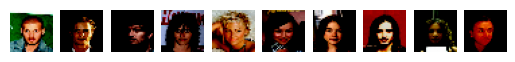

In [ ]:
def plot_images(images, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

plot_images(real_images, 1, 10)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -17.1830 - c_wass_loss: -22.0189 - c_gp: 0.4836 - g_loss: 1.3969 - c_acc: 96.1406 - g_acc: 60.7031 
Saved to ./output/generated_img_000.png


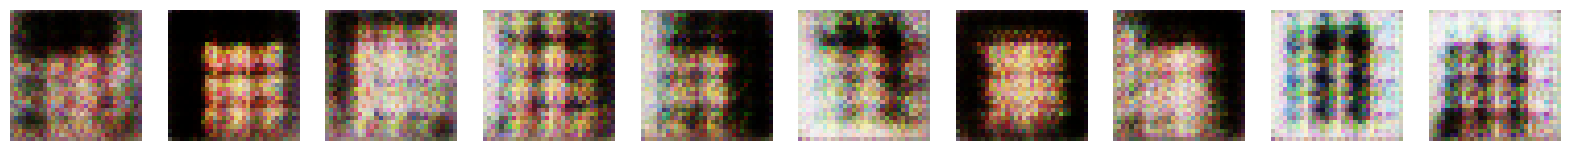

2/2 [==============================] - 3s 22ms/step
FID score at epoch 0: 493.5267793322169
100/100 [==============================] - 2389s 24s/step - c_loss: -17.1830 - c_wass_loss: -22.0189 - c_gp: 0.4836 - g_loss: 1.3969 - c_acc: 95.5446 - g_acc: 61.0767
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -5.4291 - c_wass_loss: -6.0009 - c_gp: 0.0572 - g_loss: 2.9489 - c_acc: 67.0312 - g_acc: 64.8594 
Saved to ./output/generated_img_001.png


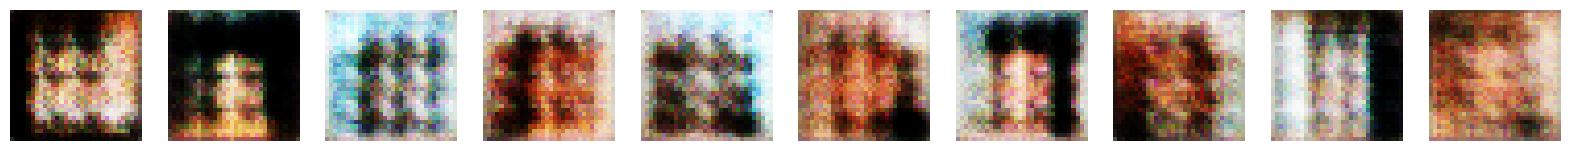

2/2 [==============================] - 0s 115ms/step
FID score at epoch 1: 502.45469777271467
100/100 [==============================] - 2389s 24s/step - c_loss: -5.4291 - c_wass_loss: -6.0009 - c_gp: 0.0572 - g_loss: 2.9489 - c_acc: 67.2184 - g_acc: 64.6968
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -4.2685 - c_wass_loss: -4.5999 - c_gp: 0.0331 - g_loss: -0.2772 - c_acc: 77.6250 - g_acc: 46.3438 
Saved to ./output/generated_img_002.png


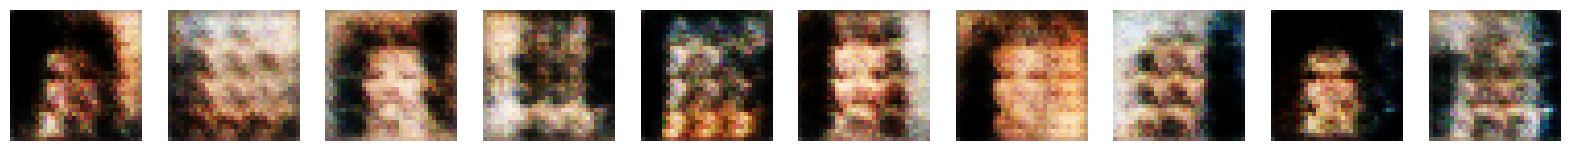

2/2 [==============================] - 0s 121ms/step
FID score at epoch 2: 473.7792914227379
100/100 [==============================] - 2390s 24s/step - c_loss: -4.2685 - c_wass_loss: -4.5999 - c_gp: 0.0331 - g_loss: -0.2772 - c_acc: 77.6454 - g_acc: 46.3645
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -4.3166 - c_wass_loss: -4.6829 - c_gp: 0.0366 - g_loss: -5.7354 - c_acc: 91.3281 - g_acc: 23.7656 
Saved to ./output/generated_img_003.png


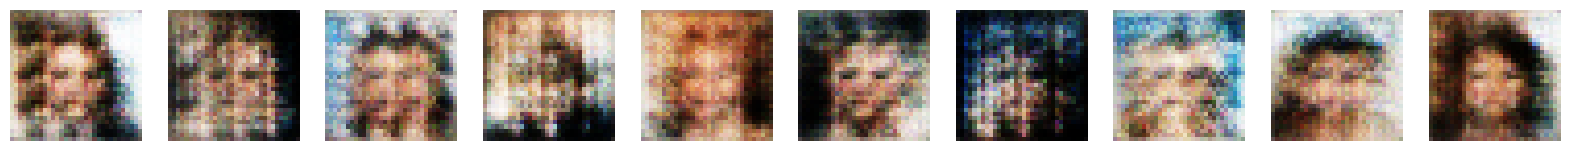

2/2 [==============================] - 0s 119ms/step
FID score at epoch 3: 556.8313350104054
100/100 [==============================] - 2396s 24s/step - c_loss: -4.3166 - c_wass_loss: -4.6829 - c_gp: 0.0366 - g_loss: -5.7354 - c_acc: 91.4140 - g_acc: 23.5303
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -3.4255 - c_wass_loss: -3.6931 - c_gp: 0.0268 - g_loss: -10.9896 - c_acc: 97.6719 - g_acc: 6.4062 
Saved to ./output/generated_img_004.png


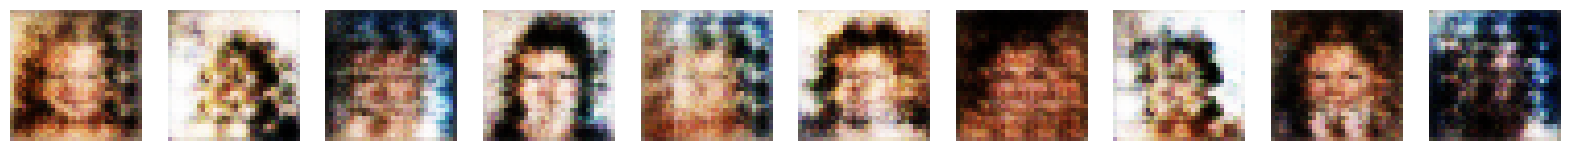

2/2 [==============================] - 0s 148ms/step
FID score at epoch 4: 547.9855622683824
100/100 [==============================] - 2385s 24s/step - c_loss: -3.4255 - c_wass_loss: -3.6931 - c_gp: 0.0268 - g_loss: -10.9896 - c_acc: 97.5712 - g_acc: 6.4975


In [23]:
loss_history = LossHistory()

wgangp.fit(
    train_data,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)


Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -3.0695 - c_wass_loss: -3.2772 - c_gp: 0.0208 - g_loss: -15.4252 - c_acc: 99.2969 - g_acc: 1.9844
Saved to ./output/generated_img_000.png


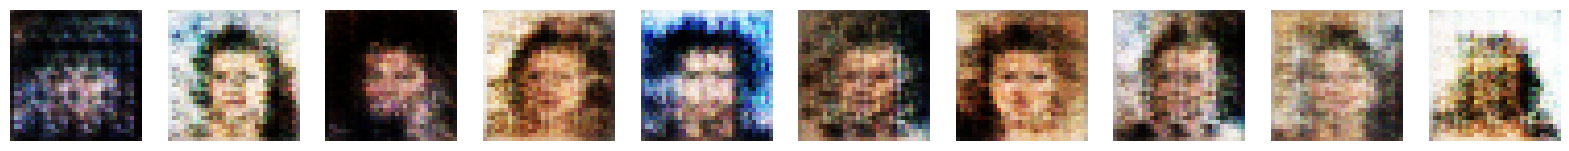

2/2 [==============================] - 0s 105ms/step
FID score at epoch 0: 512.4643691277994
100/100 [==============================] - 22s 213ms/step - c_loss: -3.0695 - c_wass_loss: -3.2772 - c_gp: 0.0208 - g_loss: -15.4252 - c_acc: 99.3038 - g_acc: 1.9647
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.8674 - c_wass_loss: -3.0384 - c_gp: 0.0171 - g_loss: -19.0364 - c_acc: 100.0000 - g_acc: 0.1562
Saved to ./output/generated_img_001.png


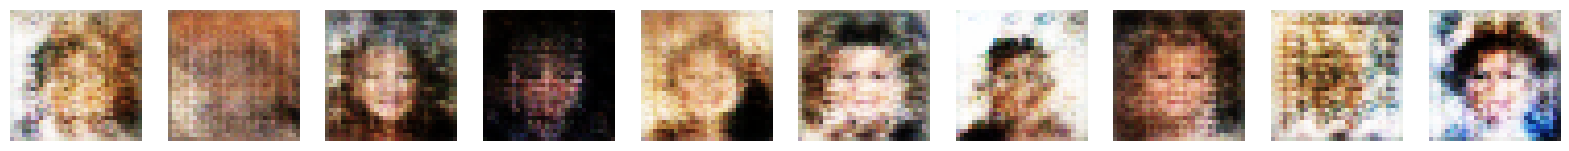

2/2 [==============================] - 0s 97ms/step
FID score at epoch 1: 541.970638802539
100/100 [==============================] - 23s 230ms/step - c_loss: -2.8674 - c_wass_loss: -3.0384 - c_gp: 0.0171 - g_loss: -19.0364 - c_acc: 100.0000 - g_acc: 0.1547
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.7040 - c_wass_loss: -2.8865 - c_gp: 0.0183 - g_loss: -22.9779 - c_acc: 99.4375 - g_acc: 1.4688
Saved to ./output/generated_img_002.png


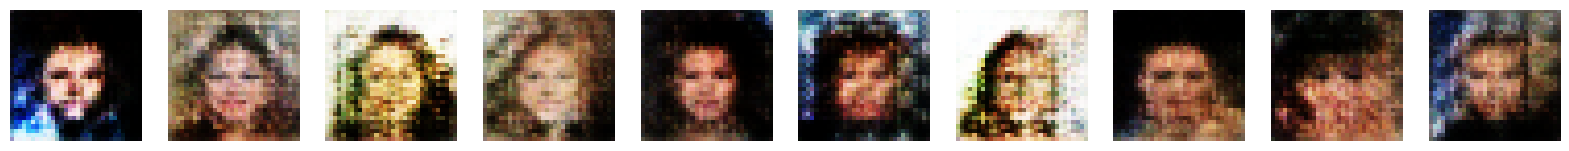

2/2 [==============================] - 0s 104ms/step
FID score at epoch 2: 608.9837175324933
100/100 [==============================] - 21s 212ms/step - c_loss: -2.7040 - c_wass_loss: -2.8865 - c_gp: 0.0183 - g_loss: -22.9779 - c_acc: 99.4431 - g_acc: 1.4542
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.7925 - c_wass_loss: -2.9677 - c_gp: 0.0175 - g_loss: -20.6901 - c_acc: 99.0469 - g_acc: 2.3281
Saved to ./output/generated_img_003.png


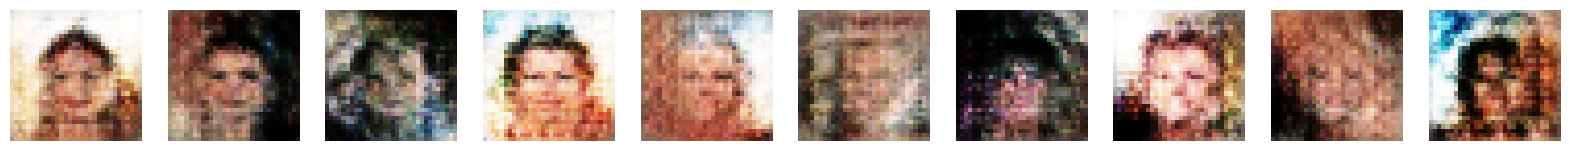

2/2 [==============================] - 0s 108ms/step
FID score at epoch 3: 587.1975069712156
100/100 [==============================] - 24s 240ms/step - c_loss: -2.7925 - c_wass_loss: -2.9677 - c_gp: 0.0175 - g_loss: -20.6901 - c_acc: 99.0408 - g_acc: 2.3205
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.5586 - c_wass_loss: -2.7222 - c_gp: 0.0164 - g_loss: -20.8216 - c_acc: 99.9375 - g_acc: 0.4062
Saved to ./output/generated_img_004.png


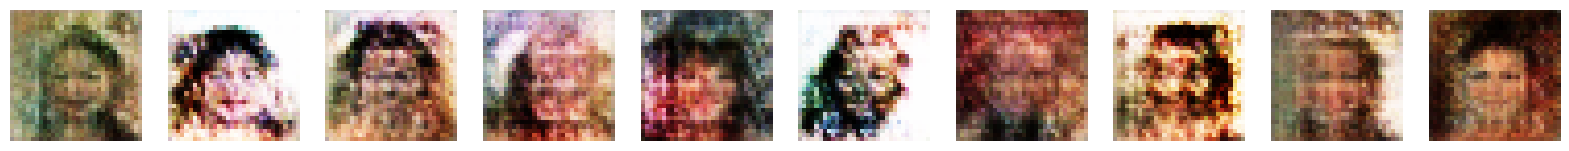

2/2 [==============================] - 0s 101ms/step
FID score at epoch 4: 577.8564823425011
100/100 [==============================] - 21s 209ms/step - c_loss: -2.5586 - c_wass_loss: -2.7222 - c_gp: 0.0164 - g_loss: -20.8216 - c_acc: 99.9226 - g_acc: 0.4022


In [24]:
wgangp.fit(
    train_data,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -2.7194 - c_wass_loss: -2.9024 - c_gp: 0.0183 - g_loss: -17.8225 - c_acc: 99.1094 - g_acc: 2.6094
Saved to ./output/generated_img_000.png


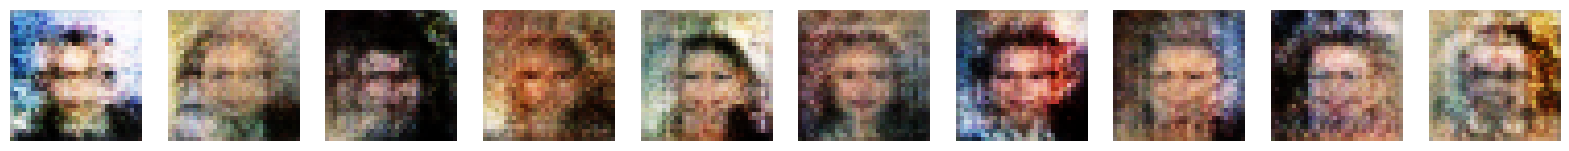

2/2 [==============================] - 0s 110ms/step
FID score at epoch 0: 586.7891589571433
100/100 [==============================] - 25s 242ms/step - c_loss: -2.7194 - c_wass_loss: -2.9024 - c_gp: 0.0183 - g_loss: -17.8225 - c_acc: 98.9790 - g_acc: 2.9084
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.6698 - c_wass_loss: -2.8398 - c_gp: 0.0170 - g_loss: -17.6765 - c_acc: 99.3281 - g_acc: 1.0469
Saved to ./output/generated_img_001.png


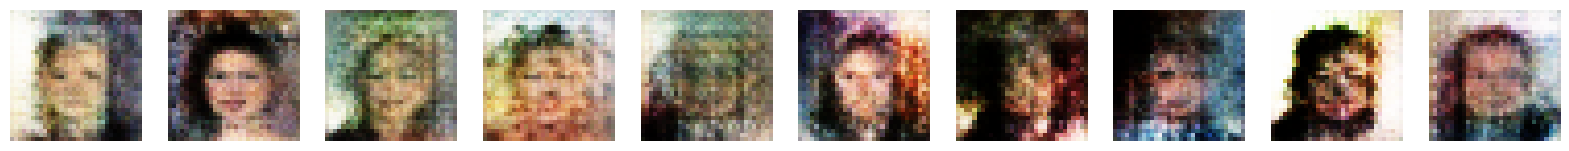

2/2 [==============================] - 0s 104ms/step
FID score at epoch 1: 608.0029983514834
100/100 [==============================] - 23s 229ms/step - c_loss: -2.6698 - c_wass_loss: -2.8398 - c_gp: 0.0170 - g_loss: -17.6765 - c_acc: 99.3348 - g_acc: 1.0365
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.6271 - c_wass_loss: -2.8248 - c_gp: 0.0198 - g_loss: -21.7923 - c_acc: 99.5156 - g_acc: 0.8594
Saved to ./output/generated_img_002.png


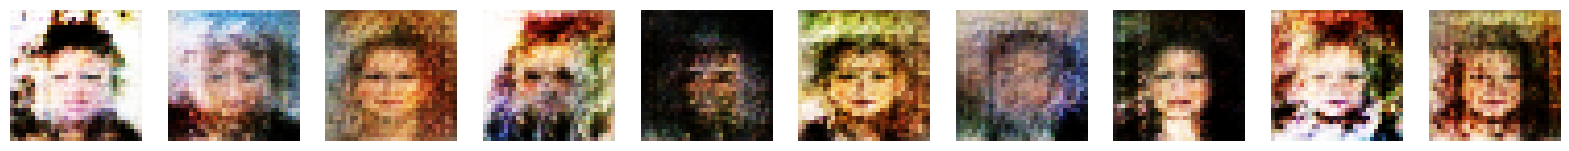

2/2 [==============================] - 0s 104ms/step
FID score at epoch 2: 638.3594597192684
100/100 [==============================] - 23s 227ms/step - c_loss: -2.6271 - c_wass_loss: -2.8248 - c_gp: 0.0198 - g_loss: -21.7923 - c_acc: 99.5050 - g_acc: 0.8818
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.8653 - c_wass_loss: -3.0630 - c_gp: 0.0198 - g_loss: -22.8071 - c_acc: 99.6406 - g_acc: 0.9375
Saved to ./output/generated_img_003.png


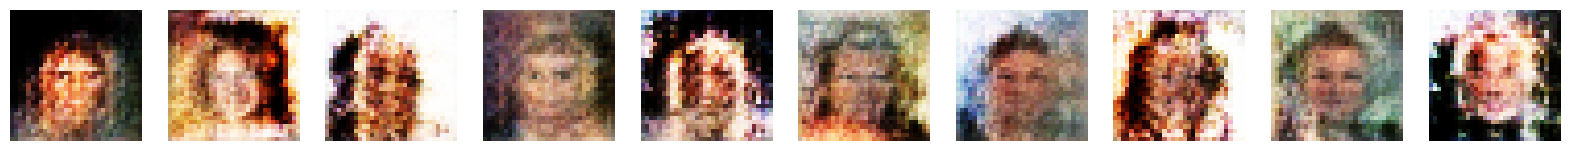

2/2 [==============================] - 0s 105ms/step
FID score at epoch 3: 628.247797614622
100/100 [==============================] - 24s 239ms/step - c_loss: -2.8653 - c_wass_loss: -3.0630 - c_gp: 0.0198 - g_loss: -22.8071 - c_acc: 99.6442 - g_acc: 0.9282
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.5256 - c_wass_loss: -2.7126 - c_gp: 0.0187 - g_loss: -24.8842 - c_acc: 99.9844 - g_acc: 0.1250
Saved to ./output/generated_img_004.png


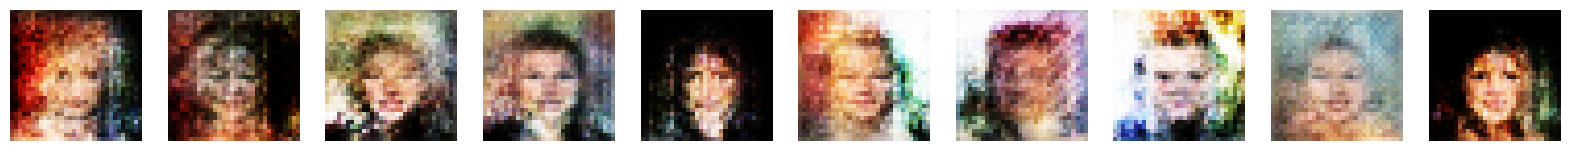

2/2 [==============================] - 0s 129ms/step
FID score at epoch 4: 622.7161440339914
100/100 [==============================] - 23s 235ms/step - c_loss: -2.5256 - c_wass_loss: -2.7126 - c_gp: 0.0187 - g_loss: -24.8842 - c_acc: 99.9845 - g_acc: 0.1238


In [25]:
wgangp.fit(
    train_data,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -2.7327 - c_wass_loss: -2.9241 - c_gp: 0.0191 - g_loss: -28.5528 - c_acc: 100.0000 - g_acc: 0.0312
Saved to ./output/generated_img_000.png


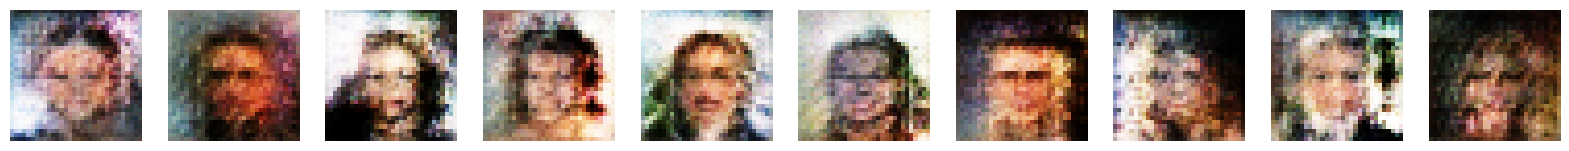

2/2 [==============================] - 0s 128ms/step
FID score at epoch 0: 624.2625147661656
100/100 [==============================] - 23s 224ms/step - c_loss: -2.7327 - c_wass_loss: -2.9241 - c_gp: 0.0191 - g_loss: -28.5528 - c_acc: 100.0000 - g_acc: 0.0309
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.5052 - c_wass_loss: -2.6689 - c_gp: 0.0164 - g_loss: -32.5341 - c_acc: 100.0000 - g_acc: 0.0156
Saved to ./output/generated_img_001.png


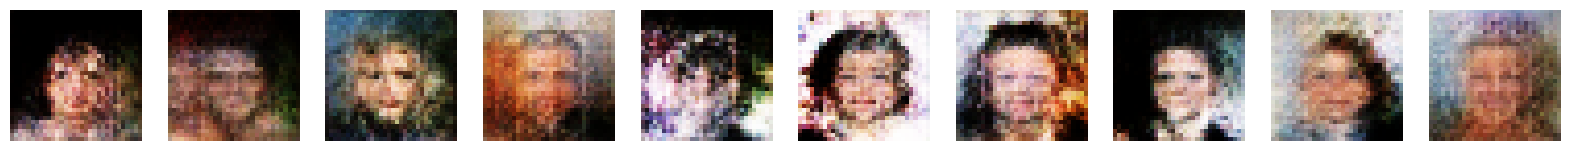

2/2 [==============================] - 0s 106ms/step
FID score at epoch 1: 596.144588233755
100/100 [==============================] - 23s 233ms/step - c_loss: -2.5052 - c_wass_loss: -2.6689 - c_gp: 0.0164 - g_loss: -32.5341 - c_acc: 100.0000 - g_acc: 0.0155
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.7497 - c_wass_loss: -2.9500 - c_gp: 0.0200 - g_loss: -30.8843 - c_acc: 99.9844 - g_acc: 0.0938
Saved to ./output/generated_img_002.png


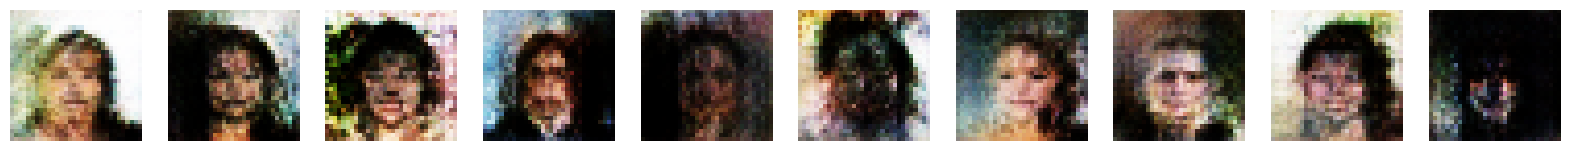

2/2 [==============================] - 0s 106ms/step
FID score at epoch 2: 577.0495205925139
100/100 [==============================] - 22s 223ms/step - c_loss: -2.7497 - c_wass_loss: -2.9500 - c_gp: 0.0200 - g_loss: -30.8843 - c_acc: 99.9845 - g_acc: 0.0928
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.5606 - c_wass_loss: -2.7630 - c_gp: 0.0202 - g_loss: -29.6780 - c_acc: 99.8906 - g_acc: 0.2812
Saved to ./output/generated_img_003.png


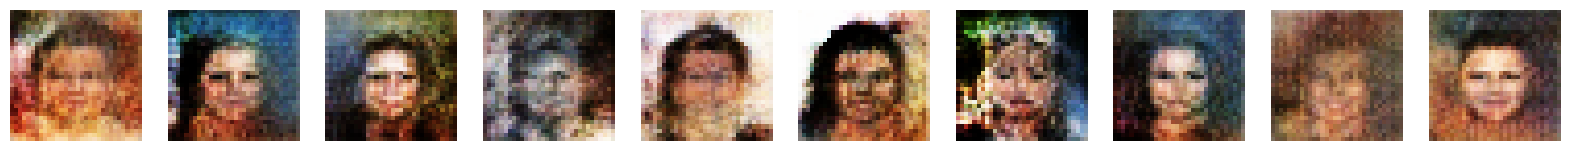

2/2 [==============================] - 0s 105ms/step
FID score at epoch 3: 622.7933305087467
100/100 [==============================] - 22s 226ms/step - c_loss: -2.5606 - c_wass_loss: -2.7630 - c_gp: 0.0202 - g_loss: -29.6780 - c_acc: 99.8917 - g_acc: 0.2785
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.8128 - c_wass_loss: -3.0145 - c_gp: 0.0202 - g_loss: -32.8819 - c_acc: 100.0000 - g_acc: 0.0156
Saved to ./output/generated_img_004.png


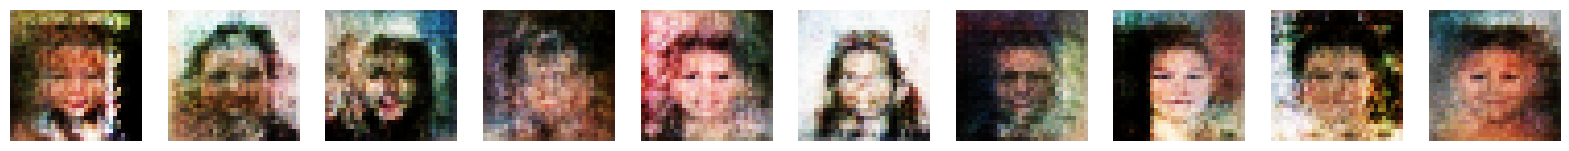

2/2 [==============================] - 0s 107ms/step
FID score at epoch 4: 593.4390603994631
100/100 [==============================] - 23s 233ms/step - c_loss: -2.8128 - c_wass_loss: -3.0145 - c_gp: 0.0202 - g_loss: -32.8819 - c_acc: 100.0000 - g_acc: 0.0155


In [26]:
wgangp.fit(
    train_data,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -2.4775 - c_wass_loss: -2.6538 - c_gp: 0.0176 - g_loss: -32.3421 - c_acc: 100.0000 - g_acc: 0.0000e+00
Saved to ./output/generated_img_000.png


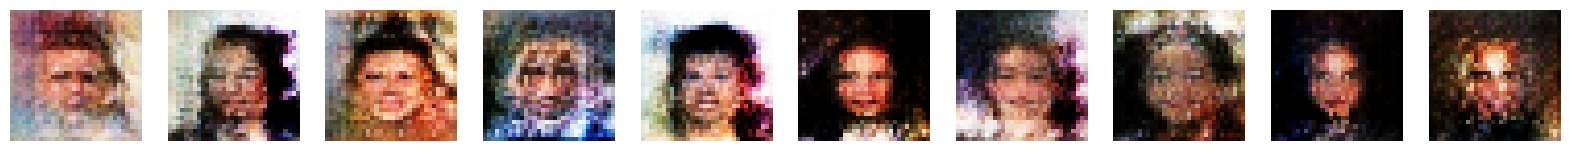

2/2 [==============================] - 0s 107ms/step
FID score at epoch 0: 655.1479534435734
100/100 [==============================] - 23s 222ms/step - c_loss: -2.4775 - c_wass_loss: -2.6538 - c_gp: 0.0176 - g_loss: -32.3421 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.2653 - c_wass_loss: -2.4360 - c_gp: 0.0171 - g_loss: -32.4247 - c_acc: 100.0000 - g_acc: 0.0312
Saved to ./output/generated_img_001.png


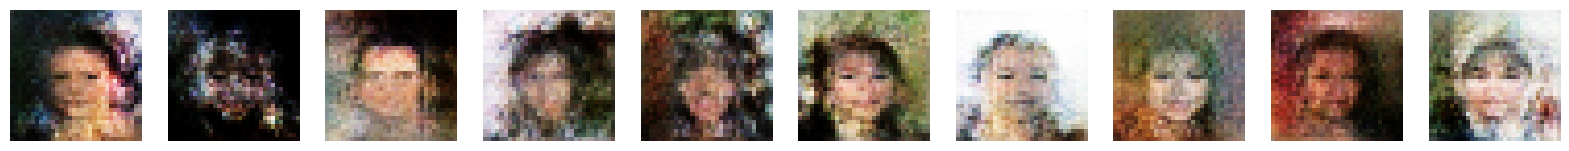

2/2 [==============================] - 0s 106ms/step
FID score at epoch 1: 617.8188026770923
100/100 [==============================] - 23s 227ms/step - c_loss: -2.2653 - c_wass_loss: -2.4360 - c_gp: 0.0171 - g_loss: -32.4247 - c_acc: 100.0000 - g_acc: 0.0309
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.5374 - c_wass_loss: -2.7395 - c_gp: 0.0202 - g_loss: -32.1167 - c_acc: 100.0000 - g_acc: 0.0156
Saved to ./output/generated_img_002.png


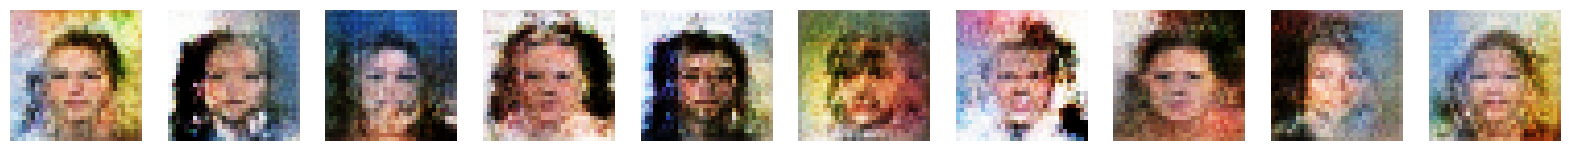

2/2 [==============================] - 0s 103ms/step
FID score at epoch 2: 657.5539126270771
100/100 [==============================] - 22s 224ms/step - c_loss: -2.5374 - c_wass_loss: -2.7395 - c_gp: 0.0202 - g_loss: -32.1167 - c_acc: 100.0000 - g_acc: 0.0155
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.4803 - c_wass_loss: -2.6679 - c_gp: 0.0188 - g_loss: -34.1304 - c_acc: 99.9844 - g_acc: 0.0000e+00
Saved to ./output/generated_img_003.png


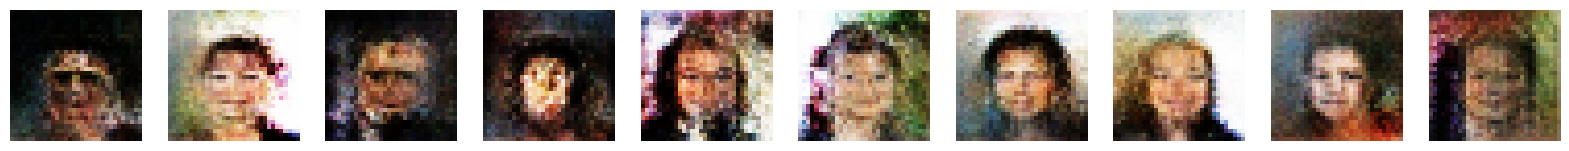

2/2 [==============================] - 0s 108ms/step
FID score at epoch 3: 626.0223578347205
100/100 [==============================] - 22s 220ms/step - c_loss: -2.4803 - c_wass_loss: -2.6679 - c_gp: 0.0188 - g_loss: -34.1304 - c_acc: 99.9845 - g_acc: 0.0000e+00
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3687 - c_wass_loss: -2.5635 - c_gp: 0.0195 - g_loss: -32.5188 - c_acc: 99.9375 - g_acc: 0.2188
Saved to ./output/generated_img_004.png


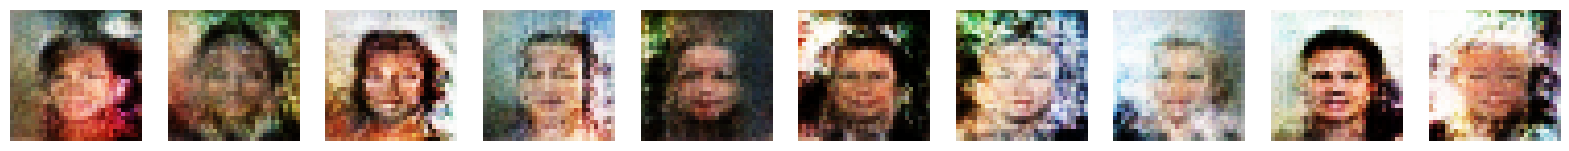

2/2 [==============================] - 0s 106ms/step
FID score at epoch 4: 645.3784404761252
100/100 [==============================] - 23s 232ms/step - c_loss: -2.3687 - c_wass_loss: -2.5635 - c_gp: 0.0195 - g_loss: -32.5188 - c_acc: 99.9381 - g_acc: 0.2166


In [27]:
wgangp.fit(
    train_data,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3659 - c_wass_loss: -2.5411 - c_gp: 0.0175 - g_loss: -33.6673 - c_acc: 99.9844 - g_acc: 0.0156
Saved to ./output/generated_img_000.png


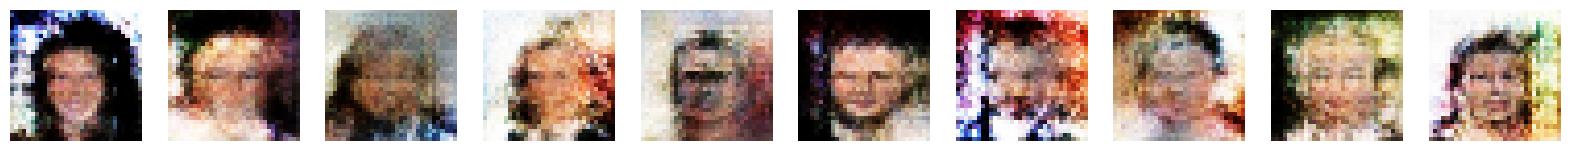

2/2 [==============================] - 0s 116ms/step
FID score at epoch 0: 627.2652304816495
100/100 [==============================] - 27s 246ms/step - c_loss: -2.3659 - c_wass_loss: -2.5411 - c_gp: 0.0175 - g_loss: -33.6673 - c_acc: 99.9845 - g_acc: 0.0155
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.5386 - c_wass_loss: -2.7588 - c_gp: 0.0220 - g_loss: -34.8509 - c_acc: 100.0000 - g_acc: 0.0312
Saved to ./output/generated_img_001.png


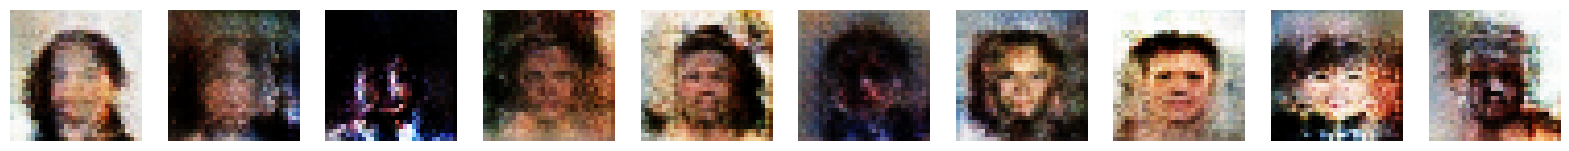

2/2 [==============================] - 0s 103ms/step
FID score at epoch 1: 603.7229061581011
100/100 [==============================] - 25s 250ms/step - c_loss: -2.5386 - c_wass_loss: -2.7588 - c_gp: 0.0220 - g_loss: -34.8509 - c_acc: 100.0000 - g_acc: 0.0309
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.2259 - c_wass_loss: -2.4038 - c_gp: 0.0178 - g_loss: -33.2442 - c_acc: 99.7344 - g_acc: 0.3750
Saved to ./output/generated_img_002.png


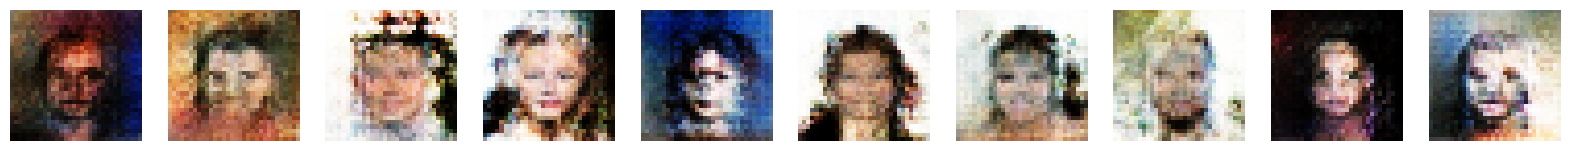

2/2 [==============================] - 0s 105ms/step
FID score at epoch 2: 607.7271792477774
100/100 [==============================] - 26s 265ms/step - c_loss: -2.2259 - c_wass_loss: -2.4038 - c_gp: 0.0178 - g_loss: -33.2442 - c_acc: 99.7370 - g_acc: 0.3713
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3291 - c_wass_loss: -2.5093 - c_gp: 0.0180 - g_loss: -29.5524 - c_acc: 99.9688 - g_acc: 0.0469
Saved to ./output/generated_img_003.png


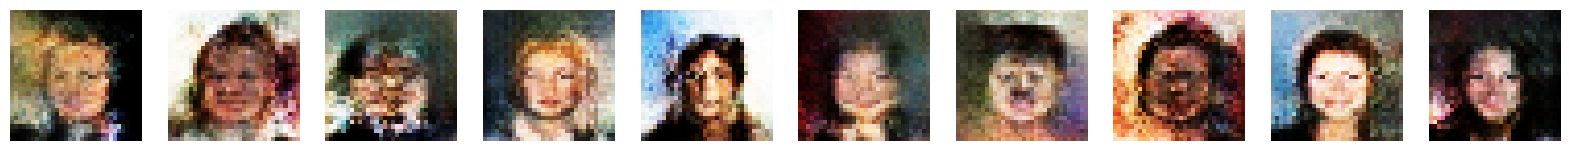

2/2 [==============================] - 0s 150ms/step
FID score at epoch 3: 580.108494129415
100/100 [==============================] - 23s 231ms/step - c_loss: -2.3291 - c_wass_loss: -2.5093 - c_gp: 0.0180 - g_loss: -29.5524 - c_acc: 99.9691 - g_acc: 0.0464
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3481 - c_wass_loss: -2.5299 - c_gp: 0.0182 - g_loss: -33.7490 - c_acc: 100.0000 - g_acc: 0.0156
Saved to ./output/generated_img_004.png


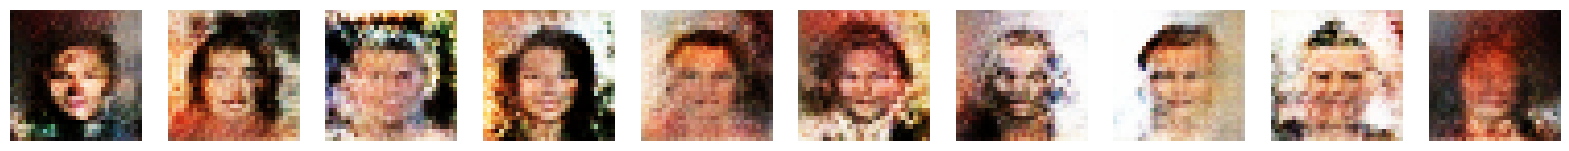

2/2 [==============================] - 0s 105ms/step
FID score at epoch 4: 600.8854363908214
100/100 [==============================] - 25s 247ms/step - c_loss: -2.3481 - c_wass_loss: -2.5299 - c_gp: 0.0182 - g_loss: -33.7490 - c_acc: 100.0000 - g_acc: 0.0155


In [28]:
wgangp.fit(
    train_data,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -2.2744 - c_wass_loss: -2.4453 - c_gp: 0.0171 - g_loss: -29.1845 - c_acc: 100.0000 - g_acc: 0.0156
Saved to ./output/generated_img_000.png


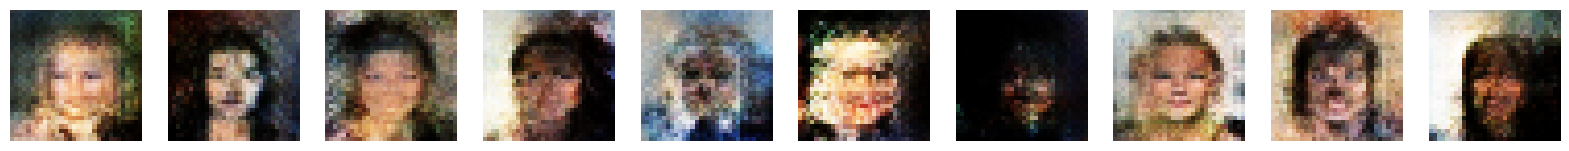

2/2 [==============================] - 0s 133ms/step
FID score at epoch 0: 609.5553977207173
100/100 [==============================] - 24s 232ms/step - c_loss: -2.2744 - c_wass_loss: -2.4453 - c_gp: 0.0171 - g_loss: -29.1845 - c_acc: 100.0000 - g_acc: 0.0155
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3268 - c_wass_loss: -2.5187 - c_gp: 0.0192 - g_loss: -31.4024 - c_acc: 100.0000 - g_acc: 0.0000e+00
Saved to ./output/generated_img_001.png


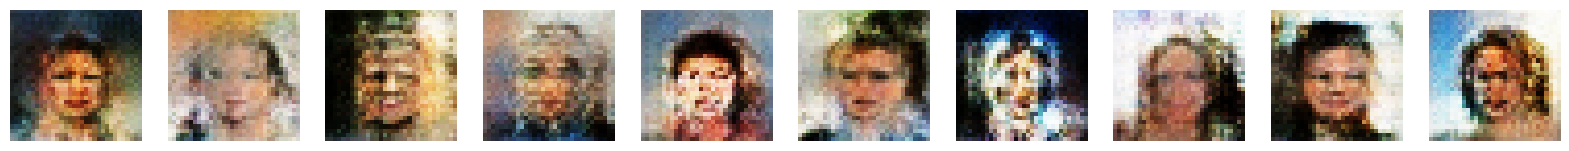

2/2 [==============================] - 0s 107ms/step
FID score at epoch 1: 673.8468838322303
100/100 [==============================] - 24s 239ms/step - c_loss: -2.3268 - c_wass_loss: -2.5187 - c_gp: 0.0192 - g_loss: -31.4024 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.2122 - c_wass_loss: -2.3991 - c_gp: 0.0187 - g_loss: -28.2094 - c_acc: 100.0000 - g_acc: 0.0000e+00
Saved to ./output/generated_img_002.png


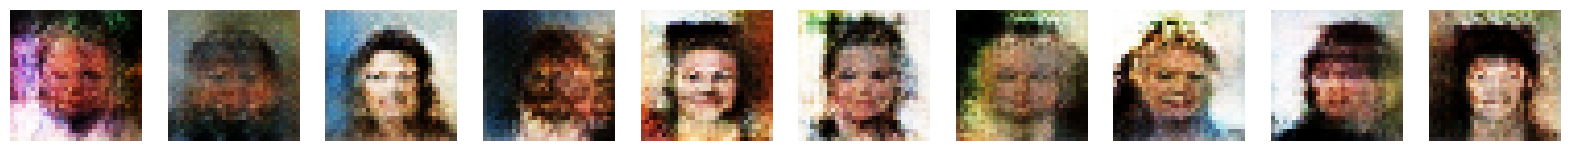

2/2 [==============================] - 0s 103ms/step
FID score at epoch 2: 621.5137372735076
100/100 [==============================] - 24s 245ms/step - c_loss: -2.2122 - c_wass_loss: -2.3991 - c_gp: 0.0187 - g_loss: -28.2094 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.4128 - c_wass_loss: -2.6400 - c_gp: 0.0227 - g_loss: -28.6552 - c_acc: 99.7500 - g_acc: 0.2188
Saved to ./output/generated_img_003.png


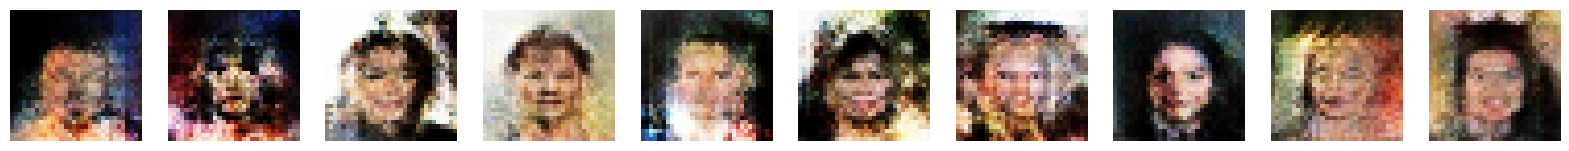

2/2 [==============================] - 0s 105ms/step
FID score at epoch 3: 697.8550396143547
100/100 [==============================] - 28s 284ms/step - c_loss: -2.4128 - c_wass_loss: -2.6400 - c_gp: 0.0227 - g_loss: -28.6552 - c_acc: 99.7525 - g_acc: 0.2166
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.5393 - c_wass_loss: -2.7286 - c_gp: 0.0189 - g_loss: -31.9920 - c_acc: 100.0000 - g_acc: 0.0938
Saved to ./output/generated_img_004.png


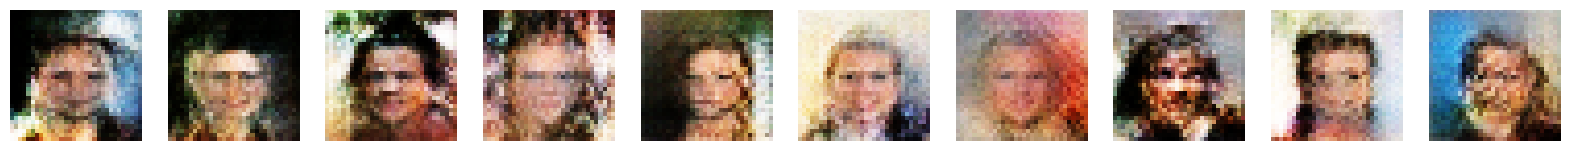

2/2 [==============================] - 0s 145ms/step
FID score at epoch 4: 637.20604071588
100/100 [==============================] - 22s 224ms/step - c_loss: -2.5393 - c_wass_loss: -2.7286 - c_gp: 0.0189 - g_loss: -31.9920 - c_acc: 100.0000 - g_acc: 0.0928


In [30]:
wgangp.fit(
    train_data,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3670 - c_wass_loss: -2.5550 - c_gp: 0.0188 - g_loss: -25.4817 - c_acc: 99.9844 - g_acc: 0.0781
Saved to ./output/generated_img_000.png


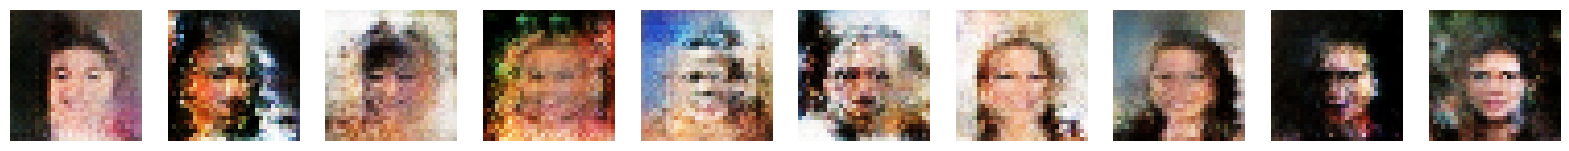

2/2 [==============================] - 0s 105ms/step
FID score at epoch 0: 658.8203673509568
100/100 [==============================] - 25s 243ms/step - c_loss: -2.3670 - c_wass_loss: -2.5550 - c_gp: 0.0188 - g_loss: -25.4817 - c_acc: 99.9845 - g_acc: 0.0774
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.4461 - c_wass_loss: -2.6478 - c_gp: 0.0202 - g_loss: -24.2262 - c_acc: 99.9531 - g_acc: 0.1562
Saved to ./output/generated_img_001.png


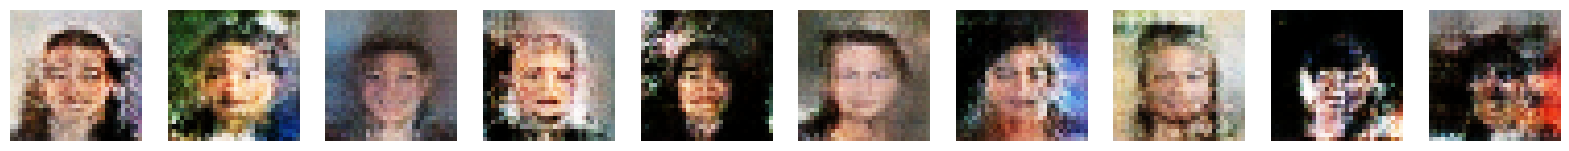

2/2 [==============================] - 0s 106ms/step
FID score at epoch 1: 643.3370245236264
100/100 [==============================] - 23s 227ms/step - c_loss: -2.4461 - c_wass_loss: -2.6478 - c_gp: 0.0202 - g_loss: -24.2262 - c_acc: 99.9536 - g_acc: 0.1547
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.4538 - c_wass_loss: -2.6350 - c_gp: 0.0181 - g_loss: -24.5741 - c_acc: 100.0000 - g_acc: 0.0312
Saved to ./output/generated_img_002.png


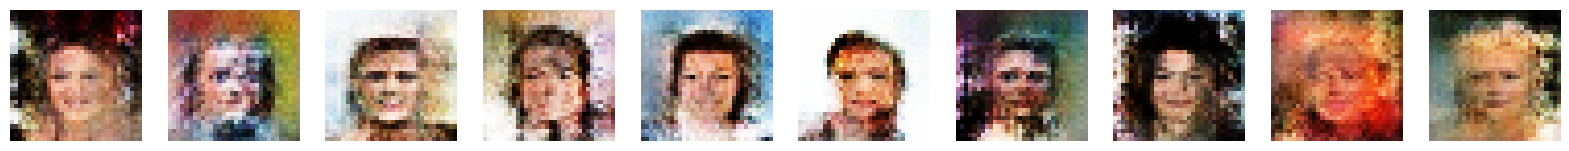

2/2 [==============================] - 0s 105ms/step
FID score at epoch 2: 695.3117227399063
100/100 [==============================] - 25s 254ms/step - c_loss: -2.4538 - c_wass_loss: -2.6350 - c_gp: 0.0181 - g_loss: -24.5741 - c_acc: 100.0000 - g_acc: 0.0309
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.5992 - c_wass_loss: -2.8319 - c_gp: 0.0233 - g_loss: -23.3573 - c_acc: 99.7031 - g_acc: 0.4219
Saved to ./output/generated_img_003.png


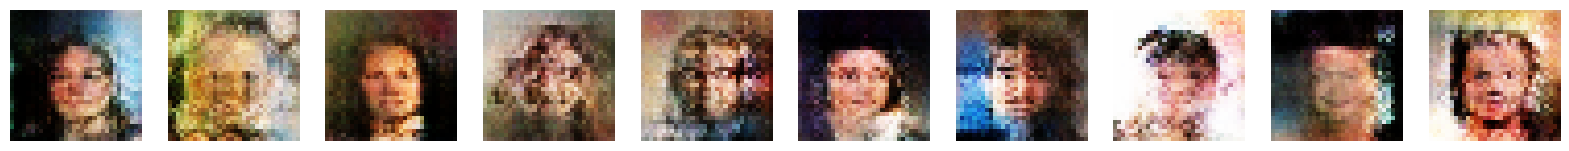

2/2 [==============================] - 0s 103ms/step
FID score at epoch 3: 667.446901405795
100/100 [==============================] - 24s 238ms/step - c_loss: -2.5992 - c_wass_loss: -2.8319 - c_gp: 0.0233 - g_loss: -23.3573 - c_acc: 99.7061 - g_acc: 0.4177
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.4464 - c_wass_loss: -2.6467 - c_gp: 0.0200 - g_loss: -26.0211 - c_acc: 99.9531 - g_acc: 0.0938
Saved to ./output/generated_img_004.png


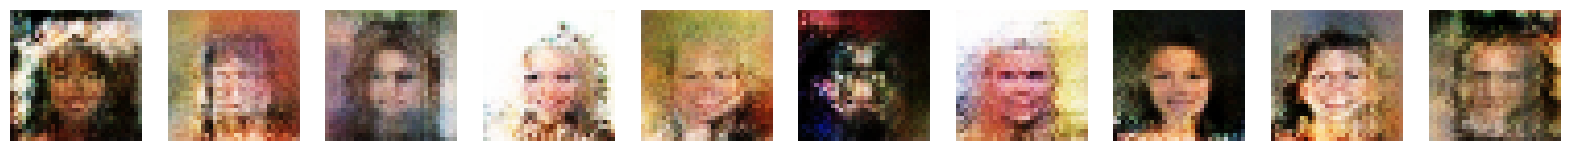

2/2 [==============================] - 0s 147ms/step
FID score at epoch 4: 674.04284984719
100/100 [==============================] - 22s 221ms/step - c_loss: -2.4464 - c_wass_loss: -2.6467 - c_gp: 0.0200 - g_loss: -26.0211 - c_acc: 99.9536 - g_acc: 0.0928


In [38]:
wgangp.fit(
    train_data,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3840 - c_wass_loss: -2.5607 - c_gp: 0.0177 - g_loss: -24.1199 - c_acc: 99.9688 - g_acc: 0.0781
Saved to ./output/generated_img_000.png


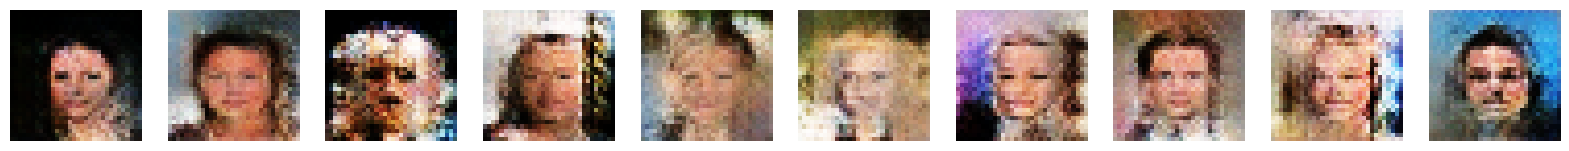

2/2 [==============================] - 0s 128ms/step
FID score at epoch 0: 710.6654446837262
100/100 [==============================] - 23s 221ms/step - c_loss: -2.3840 - c_wass_loss: -2.5607 - c_gp: 0.0177 - g_loss: -24.1199 - c_acc: 99.9691 - g_acc: 0.0774
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.5307 - c_wass_loss: -2.7248 - c_gp: 0.0194 - g_loss: -23.8939 - c_acc: 99.9531 - g_acc: 0.1875
Saved to ./output/generated_img_001.png


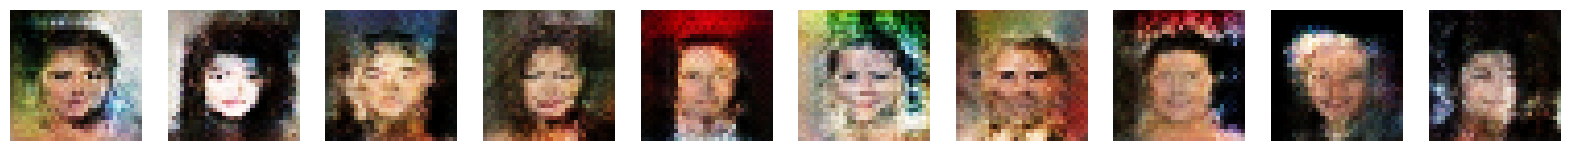

2/2 [==============================] - 0s 105ms/step
FID score at epoch 1: 638.383371411278
100/100 [==============================] - 27s 268ms/step - c_loss: -2.5307 - c_wass_loss: -2.7248 - c_gp: 0.0194 - g_loss: -23.8939 - c_acc: 99.9536 - g_acc: 0.1856
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.4498 - c_wass_loss: -2.6678 - c_gp: 0.0218 - g_loss: -21.9872 - c_acc: 99.7812 - g_acc: 0.3281
Saved to ./output/generated_img_002.png


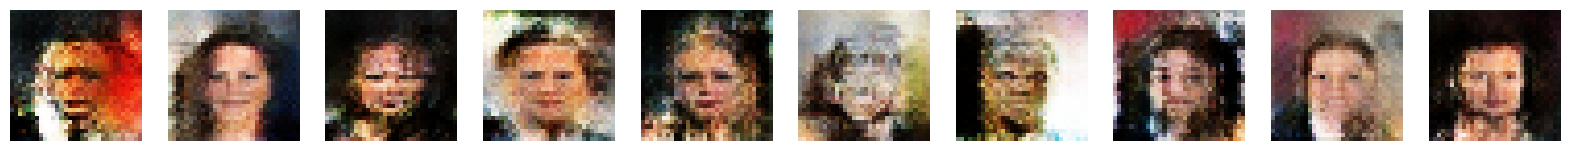

2/2 [==============================] - 0s 99ms/step
FID score at epoch 2: 630.0765418445466
100/100 [==============================] - 32s 320ms/step - c_loss: -2.4498 - c_wass_loss: -2.6678 - c_gp: 0.0218 - g_loss: -21.9872 - c_acc: 99.7834 - g_acc: 0.3249
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3680 - c_wass_loss: -2.5587 - c_gp: 0.0191 - g_loss: -20.4904 - c_acc: 99.6875 - g_acc: 0.8125
Saved to ./output/generated_img_003.png


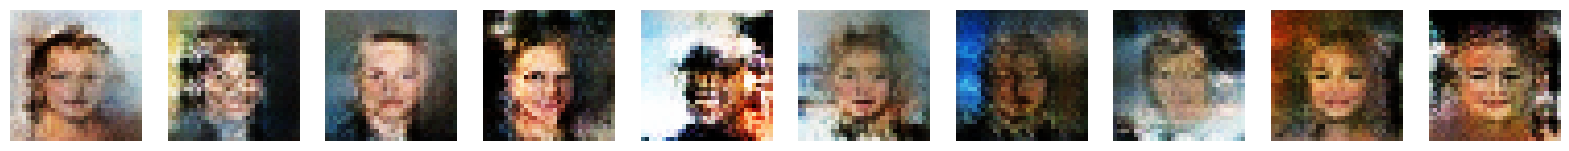

2/2 [==============================] - 0s 127ms/step
FID score at epoch 3: 604.3275537328219
100/100 [==============================] - 28s 280ms/step - c_loss: -2.3680 - c_wass_loss: -2.5587 - c_gp: 0.0191 - g_loss: -20.4904 - c_acc: 99.6906 - g_acc: 0.8045
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.4102 - c_wass_loss: -2.5996 - c_gp: 0.0189 - g_loss: -20.4608 - c_acc: 99.9375 - g_acc: 0.3125
Saved to ./output/generated_img_004.png


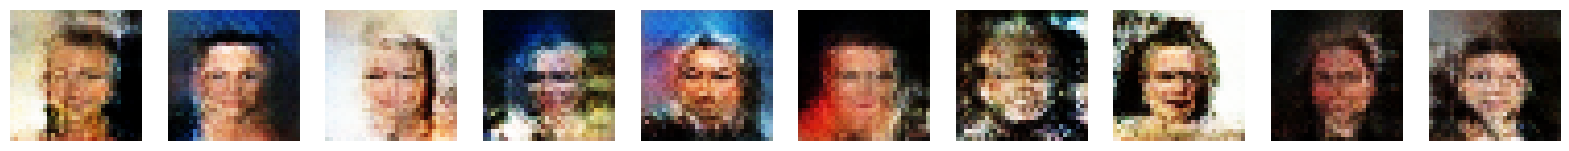

2/2 [==============================] - 0s 107ms/step
FID score at epoch 4: 579.0621630254664
100/100 [==============================] - 24s 243ms/step - c_loss: -2.4102 - c_wass_loss: -2.5996 - c_gp: 0.0189 - g_loss: -20.4608 - c_acc: 99.9381 - g_acc: 0.3094


In [43]:
wgangp.fit(
    train_data,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -2.1706 - c_wass_loss: -2.3390 - c_gp: 0.0168 - g_loss: -20.4897 - c_acc: 99.9688 - g_acc: 0.1250
Saved to ./output/generated_img_000.png


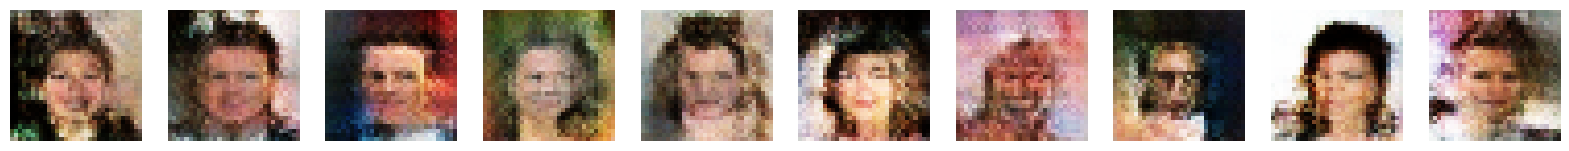

2/2 [==============================] - 0s 107ms/step
FID score at epoch 0: 686.7589521099995
100/100 [==============================] - 27s 261ms/step - c_loss: -2.1706 - c_wass_loss: -2.3390 - c_gp: 0.0168 - g_loss: -20.4897 - c_acc: 99.9691 - g_acc: 0.1238
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3886 - c_wass_loss: -2.5705 - c_gp: 0.0182 - g_loss: -20.4679 - c_acc: 99.9531 - g_acc: 0.1875
Saved to ./output/generated_img_001.png


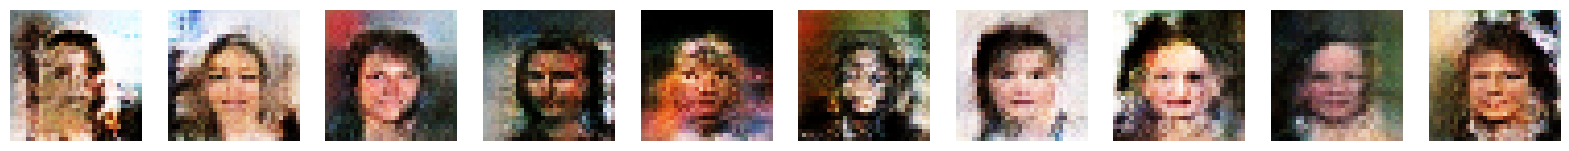

2/2 [==============================] - 0s 108ms/step
FID score at epoch 1: 609.3735232977904
100/100 [==============================] - 23s 235ms/step - c_loss: -2.3886 - c_wass_loss: -2.5705 - c_gp: 0.0182 - g_loss: -20.4679 - c_acc: 99.9381 - g_acc: 0.2166
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3808 - c_wass_loss: -2.5639 - c_gp: 0.0183 - g_loss: -19.6400 - c_acc: 99.8594 - g_acc: 0.4219
Saved to ./output/generated_img_002.png


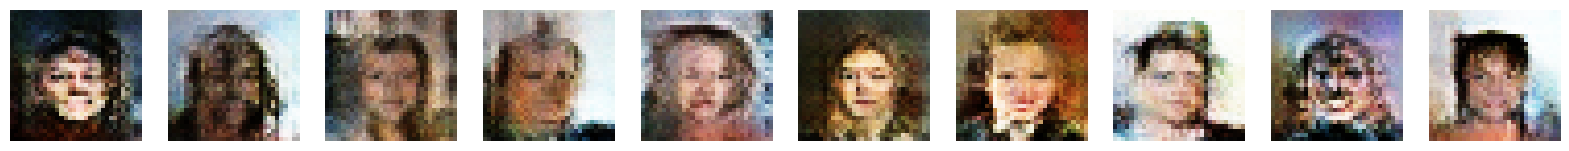

2/2 [==============================] - 0s 104ms/step
FID score at epoch 2: 698.6867653859402
100/100 [==============================] - 24s 241ms/step - c_loss: -2.3808 - c_wass_loss: -2.5639 - c_gp: 0.0183 - g_loss: -19.6400 - c_acc: 99.8608 - g_acc: 0.4177
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.3523 - c_wass_loss: -2.5422 - c_gp: 0.0190 - g_loss: -20.1765 - c_acc: 99.8906 - g_acc: 0.2812
Saved to ./output/generated_img_003.png


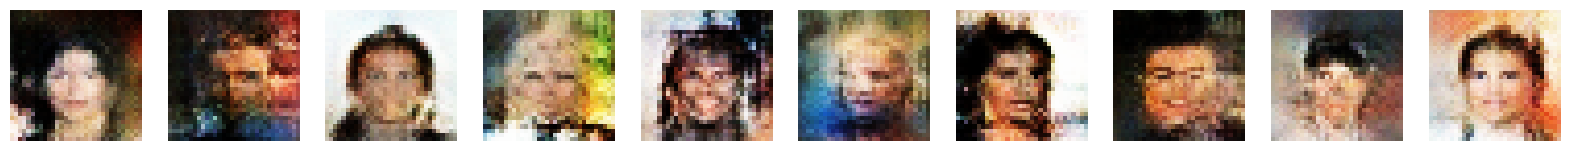

2/2 [==============================] - 0s 105ms/step
FID score at epoch 3: 673.6573114717262
100/100 [==============================] - 23s 227ms/step - c_loss: -2.3523 - c_wass_loss: -2.5422 - c_gp: 0.0190 - g_loss: -20.1765 - c_acc: 99.8917 - g_acc: 0.2785
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.2813 - c_wass_loss: -2.4510 - c_gp: 0.0170 - g_loss: -19.4007 - c_acc: 99.8281 - g_acc: 0.6406
Saved to ./output/generated_img_004.png


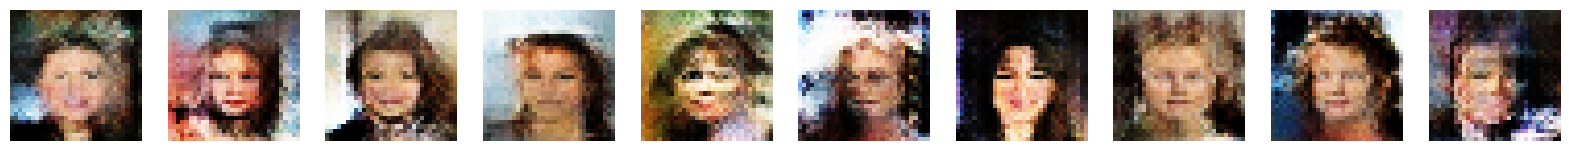

2/2 [==============================] - 0s 105ms/step
FID score at epoch 4: 616.2873318444346
100/100 [==============================] - 24s 237ms/step - c_loss: -2.2813 - c_wass_loss: -2.4510 - c_gp: 0.0170 - g_loss: -19.4007 - c_acc: 99.8298 - g_acc: 0.6807


In [44]:
wgangp.fit(
    train_data,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

In [45]:
# Save the final models
#generator.save("./models/generator")
#critic.save("./models/critic")
generator.save("./content/drive/MyDrive/DL_GANS/models/generator")
critic.save("./content/drive/MyDrive/DL_GANS/models/critic")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved models
gen = load_model("./content/drive/MyDrive/DL_GANS/models/generator")
crit= load_model("./content/drive/MyDrive/DL_GANS/models/critic")

# Create a GAN
wgangp2 = WGANGP(critic=crit, generator=gen, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

wgangp2.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)


# Show images

1/1 [==============================] - 0s 30ms/step


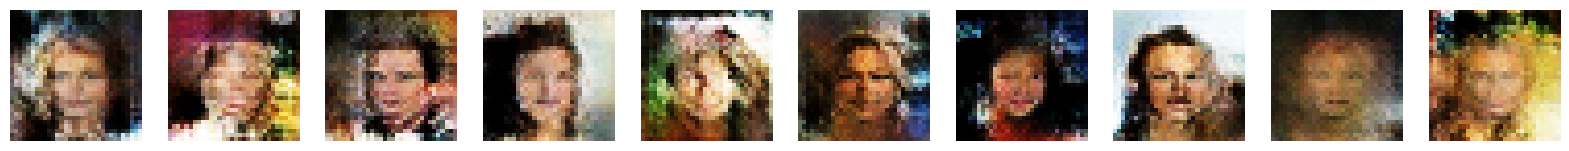

In [46]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

1/1 [==============================] - 0s 20ms/step


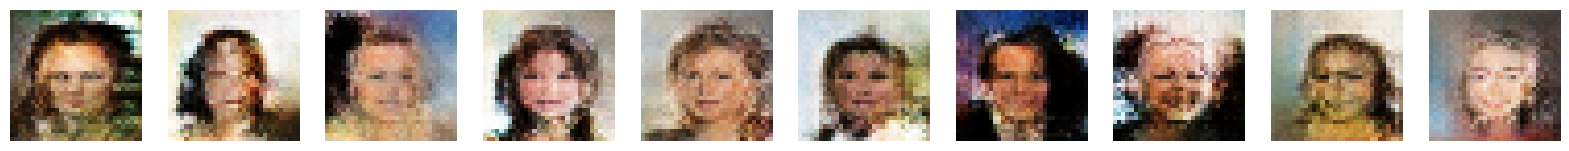

In [51]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

1/1 [==============================] - 0s 19ms/step


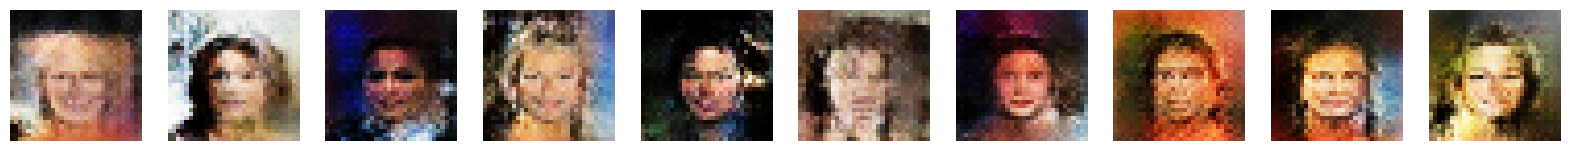

In [48]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

# Interpolate

In [52]:
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)

1/1 [==============================] - 0s 18ms/step


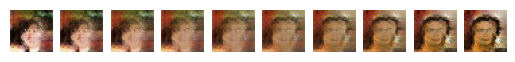

In [53]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input


def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)


def plot_generated(examples, n):
    # plot images
    for i in range(n):
        # define subplot
        pyplot.subplot(1, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

pts = generate_latent_points(Z_DIM, 2)

interpolated = interpolate_points(pts[0], pts[1])

X = wgangp.generator.predict(interpolated)
X = (X + 1) / 2.0

plot_generated(X, len(interpolated))

1/1 [==============================] - 0s 28ms/step


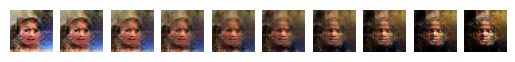

In [54]:
pts = generate_latent_points(Z_DIM, 2)

interpolated = interpolate_points(pts[0], pts[1])

X = wgangp.generator.predict(interpolated)
X = (X + 1) / 2.0

plot_generated(X, len(interpolated))

1/1 [==============================] - 0s 32ms/step


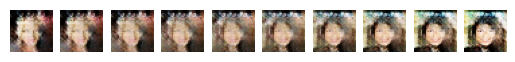

In [55]:
pts = generate_latent_points(Z_DIM, 2)

interpolated = interpolate_points(pts[0], pts[1])

X = wgangp.generator.predict(interpolated)
X = (X + 1) / 2.0

plot_generated(X, len(interpolated))